## MIE1624 Assignment 1
Zhuojun Li
<br>
999697476

In [1]:
import pandas as pd
import numpy as np
from itertools import chain
from glob import glob
import re
import html
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.model_selection import learning_curve

import seaborn as sns

### 1. Data Cleaning
Before importing the tweets into list/dataframe, we need to to pre-process and remove noises.<br>
Five functions are first created to remove or replace the noises in the file. Then the dataCleaning function is used to call all previous functions and perform the data cleaning task.
- The red comments describe the ability of each function.
- The green comments (either on top of or right after the code) explain the purpose of each step.

In [2]:
def remove_tags(file):
    '''
    The remove_tags function removes html tags and attributes from the unclassified twitter data
    '''
    
    clean = open(file,"r")
    lines = re.sub("<[^>]+?>","",clean.read(), flags=re.MULTILINE)#remove html tags in the file
    
    return open(file,"w").writelines(lines)

In [3]:
def replace_characters(file):
    '''
    The replace_character function replaces html character codes with ASCII equivalent
    '''
    
    clean = open(file,"r")
    lines = [html.unescape(line) for line in clean]  #the unescape function converts html entities to its ascii equivalent
    
    return open(file,"w").writelines(lines)

In [4]:
def remove_URLs(file):
    '''
    The remove_URLs function removes URLs
    '''
    
    clean = open(file,"r")
    
    #consider various possible forms of urls and replace them with ""
    lines = re.sub(r'(?:(?:http|https):\/\/)?([-a-zA-Z0-9.]{2,256}\.[a-z]{2,4})\b(?:\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?', "", clean.read(), flags=re.MULTILINE)
    
    return open(file,"w").writelines(lines)

In [5]:
def convert_to_lower(file):
    '''
    The convert_to_lower function converts all characters in the text to lowercases
    '''
    
    clean = open(file,"r")
    lines = [line.lower() for line in clean]  #convert all texts in the file to lowercases
    
    return open(file,"w").writelines(lines)

In [6]:
def remove_stopwords(file, stopwords):
    '''
    The remove_stopwords function removes all stopwords
    '''
    
    lines = open(file,"r").readlines()  #put the tweets file into "lines" list
    stoplist = open(stopwords,"r").readlines()  #put the stop words file into "stoplist" list
    newlines = [] #initialize the list to store tweets after removing stop words
    newstring = "" #initialize the string to store tweet
    checkPoint = True #intialize the boolean variable to check if a stop word is found
    punctuationlist = [".",",","…","?","!","#","@","(",")",'"','“','”',":",";","-","<",">","/","&","–","«","»"]
    
    #The following nested loop is used to check stopwords in all tweets
    #loop through each tweet, first remove any punctuation in the tweet
    #then, check if it contains any stopword in the stopwords list
    #if so, replace the stopword with ""
    #if not, move on to the next stopword
    #when all the stopwords are checked for one tweet, append the tweet to the newlines list and move on to next tweet
    for line in lines:
        lineReplace = line
        for i in punctuationlist:
            lineReplace = lineReplace.replace(i," ")
        checktweets = lineReplace.split()
        for checktweet in checktweets:
            checkPoint = True
            for s in stoplist:
                if checktweet == s.strip("\n"):
                    checkPoint = False
                    break
                else:
                    continue
            if checkPoint == True:
                newstring = newstring + checktweet + " "
        
        newstring = newstring + "\n" #adding "\n" to each tweet ensures empty tweets being preserved
        newlines.append(newstring)
        newstring = ""
        
    return open(file,"w").writelines(newlines)

In [7]:
def dataCleaning(file, stop):
    '''
    The dataCleaning function is designed to clean the unclassified tweets in preparation for further analysis.
    
    '''
    
    #remove all empty lines in the original file
    templist = open(file,"r").readlines()
    for temp in templist:
        if temp == "\n":
            templist.remove(temp)
    open(file,"w").writelines(templist)
    
    #call the five functions to clean the unclassified tweets file
    remove_tags(file)
    replace_characters(file)
    remove_URLs(file)
    convert_to_lower(file)
    remove_stopwords(file,stop)
    
    return None

Call the dataCleaning function to clean unclassified tweets

In [8]:
unclassified = "unclassified_tweets.txt"  #assign the unclassified tweets file name
stopwords = "stop_words.txt"  #assign the stopwords file name

dataCleaning(unclassified, stopwords)

### 2. Exploratory Analysis
To determine the political party of a given tweet, we follow the following steps.
1. First, we generate a list of keywords related to each political party.
2. Then, we go through the text of the tweet. If there is a match to any keyword of only one party, we can conclude that the tweet is about this party. If there is a match to keywords of more than one party, we put the tweet to "mixed" category as it is about multiple parties. If there is no match to any of the keyword, we conclude that the tweet is not related to major political parties ("not_related" category).

Using the above approach, we proceed to determine the political party for all given tweets.<br>
Loop all tweets in the file and determine their relavency to political parties.

In [1]:
#create a list of keywords for each political party
kw_liberal = ["lpc","liberal","liberals","liberalparty","justin","trudeau","justintrudeau","teamtrudeau",
              "realchange","realchangenow","voteliberals","vote4change"]
kw_conservative = ["cpc","conservative","stephen","harper","pmharper", "stephenharper", "stevenharper", 
                   "conservatives","voteconservative", "votecpc"]
kw_ndp = ["ndp","tom","thomas","mulcair","tommulcair","thomasmulcair","tm4pm","ndpleader","ndpwillchangethat",
         "timeforchange"]

#create counters for each political party, mixed and not_related
#total number of the following five counts = total number of tweets
count_liberal = 0
count_conservative = 0
count_ndp = 0
count_mixed = 0
count_notrelated = 0

#create counters just for the three major parties (including mixed)
count_L = 0
count_C = 0
count_N = 0

#open the unclassified tweets file (cleaned) and store tweets into a list
lines = open("unclassified_tweets.txt","r").readlines()

#loop all tweets to count frequency of each party being mentioned in tweets
for line in lines:
    l_tag = False
    c_tag = False
    n_tag = False
    for i in kw_liberal:
        if line.find(i) == -1:
            continue
        else:
            count_liberal = count_liberal + 1
            count_L = count_L + 1
            l_tag = True
            break
    for j in kw_conservative:
        if line.find(j) == -1:
            continue
        else:
            count_conservative = count_conservative + 1
            count_C = count_C + 1
            c_tag = True
            break
    for k in kw_ndp:
        if line.find(k) == -1:
            continue
        else:
            count_ndp = count_ndp + 1
            count_N = count_N + 1
            n_tag = True
            break
    
    #adjust counts for individual parties if more than one party is mentioned in one tweet
    if l_tag == True and c_tag == True and n_tag == False:
        count_liberal = count_liberal - 1
        count_conservative = count_conservative - 1
        count_mixed = count_mixed + 1
    elif l_tag == True and c_tag == False and n_tag == True:
        count_liberal = count_liberal - 1
        count_ndp = count_ndp - 1
        count_mixed = count_mixed + 1
    elif l_tag == False and c_tag == True and n_tag == True:
        count_conservative = count_conservative - 1
        count_ndp = count_ndp - 1
        count_mixed = count_mixed + 1
    elif l_tag == True and c_tag == True and n_tag == True:
        count_liberal = count_liberal - 1
        count_conservative = count_conservative - 1
        count_ndp = count_ndp - 1
        count_mixed = count_mixed + 1
    elif l_tag == False and c_tag == False and n_tag == False:
        count_notrelated = count_notrelated + 1

print(len(lines))
print(count_liberal)
print(count_conservative)
print(count_ndp)
print(count_mixed)
print(count_notrelated)
print(count_mixed/(len(lines)-count_notrelated))

FileNotFoundError: [Errno 2] No such file or directory: 'unclassified_tweets.txt'

#### Distribution of political affiliation of the tweets
From the analysis above, we have the following result:
- Out of the 3080 tweets, there are 1712 (=3080-1368) tweets (around 55.6% of total tweets) are about the three major political parties.
- For all tweets that are about the three major parties, 536 mentioned only liberal party, 516 mentioned only conservative party, and 286 mentioned only NDP.
- Liberal and conservative parties are more frequently discussed/mentioned on twitter than NDP.
- The amount of tweets about liberal and conservative party is quite close.

#### Charts for Unclassified Data

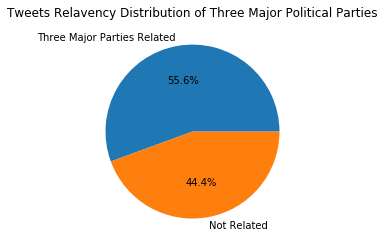

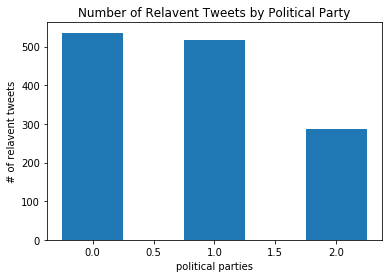

In [10]:
#Plot a pie chart for distribution of three major parties related tweets versus not related tweets

plt.figure(0)
labellist = ["Three Major Parties Related","Not Related"]
num = [len(lines) - count_notrelated, count_notrelated]

plt.axis("equal")
plt.pie(num, labels=labellist, autopct="%1.1f%%")
plt.title("Tweets Relavency Distribution of Three Major Political Parties")

#--------------------------------------------------------
#Plot a bar chart for number of tweets about each of the three major parties
plt.figure(1)
xlabellist = ("Liberal", "Conservative", "NDP")
ynumber = [count_liberal, count_conservative, count_ndp]
x = np.arange(len(ynumber))
barwidth = 0.5

plt.bar(x, ynumber, width = barwidth)
plt.xlabel("political parties")
plt.ylabel("# of relavent tweets")
plt.title("Number of Relavent Tweets by Political Party")

plt.show()

#### Chart for Classified Data

In [11]:
classifiedData = pd.read_csv("classified_tweets.txt")

In [12]:
classifiedData.head()

,class,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


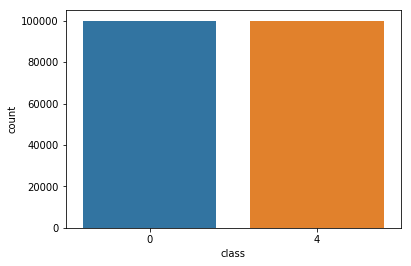

In [13]:
sns.countplot(x='class',data=classifiedData) #plot a bar chart to see the distribution of sentiment value(class)

### 3. Model Preparation


#### Prepare the classified data
Before builidng the model, we need to first modify the classified dataframe and add independent features.
- We first drop the unneeded columns: id, date, query, user
- Then, we clean the text column by removing urls, replacing html entities, converting all texts to lowercases and removing punctuations
- Finally, we remove the stop words from the text column by referencing the stop_words text file

Drop unneeded columns

In [14]:
classifiedData.drop(['id','date','query','user'],axis=1, inplace=True)

In [15]:
classifiedData.head()

,class,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


Convert to lowercases

In [16]:
classifiedData['text']=classifiedData['text'].str.lower()

Remove URLs

In [17]:
classifiedData['text']=classifiedData['text'].str.replace(r'(?:(?:http|https):\/\/)?([-a-zA-Z0-9.]{2,256}\.[a-z]{2,4})\b(?:\/[-a-zA-Z0-9@:%_\+.~#?&//=]*)?', "")

Replace html entities

In [18]:
templist = classifiedData['text'].tolist()
templist = [html.unescape(temp) for temp in templist]

Remove punctuations

In [19]:
punctuationlist = [".",",","…","?","!","#","@","(",")",'"','“','”',":","-",'&','=','<','>',';','/']
punc2 = ["'"]
numlist = ['0','1','2','3','4','5','6','7','8','9','10','20','30','40','50','00']
newlist=[]
for line in templist:
    lineReplace = line
    for i in punctuationlist:
        lineReplace = lineReplace.replace(i," ")
    for j in punc2:
        lineReplace = lineReplace.replace(j,'')
    for k in numlist:
        lineReplace = lineReplace.replace(k," ")
    newlist.append(lineReplace)

Remove stop words

In [20]:
stoplist = open(stopwords,'r').readlines()
stoplist.append('t\n')
stoplist.append('sure\n')
stop=[]
for s in stoplist:
    snew = s.strip('\n')
    stop.append(snew)

In [21]:
textn=""
newtext=[]
for l in newlist:
    checktext = l.split()
    for text in checktext:
        checkpoint = True
        for s in stop:
            if text == s:
                checkpoint = False
                break
            else:
                continue
        if checkpoint == True:
            textn = textn + text + " "
    newtext.append(textn)
    textn = ""

Add the cleaned text column to classifiedData

In [22]:
classifiedData['cleanedText']=newtext

In [23]:
classifiedData.head()

,class,text,cleanedText
0,0,"@switchfoot - awww, that's a bummer. you sho...",switchfoot awww bummer shoulda david carr thir...
1,0,is upset that he can't update his facebook by ...,upset cant update facebook texting cry result ...
2,0,@kenichan i dived many times for the ball. man...,kenichan dived times ball managed save % rest ...
3,0,my whole body feels itchy and like its on fire,body feels itchy fire
4,0,"@nationwideclass no, it's not behaving at all....",nationwideclass behaving mad cant


#### Build Model
After cleaning the text column, we add the following independent features:
1. length of each cleaned tweet
2. corpus score
3. frequency of most common 200 words

In order to calculate the values for the features, we perform the following steps:
- Get the length of each tweet
- Read the corpus list and calculate the corpus score for each tweet
- Get the top 200 most common words in classified tweets and count the frequency of each word for each tweet

Get length of tweets

In [24]:
lenoftweet = []
for i in newtext:
    lennum = len(i)
    lenoftweet.append(lennum)

Load the corpus list (word + sentiment score)<br>
Calculate sentiment score for each tweet

In [25]:
corpus = open("corpus.txt",'r').readlines()
corpuslist = []
scorelist = []
for c in corpus:
    p = c.split('\t')
    corpuslist.append(p[0])
    scorelist.append(int(p[1].strip('\n')))

In [26]:
sentilist = []
senti = 0
for tweet in newtext:
    eachword = tweet.split()
    for each in eachword:
        for keyword in corpuslist:
            if each == keyword:
                senti = senti + scorelist[corpuslist.index(keyword)]
    sentilist.append(senti)
    senti = 0

Add the two feature columns (length of tweets, corpus score) to classifiedData dataframe and intialize with 0s

In [27]:
add = pd.DataFrame(columns=['length of tweets','corpus score'])
totalDF = pd.concat([classifiedData, add])
totalDF = totalDF.fillna(value=0)

Assign the calculated feature values

In [28]:
totalDF['length of tweets'] = lenoftweet
totalDF['corpus score'] = sentilist

Drop the original "text" column and "cleanedText" column<br>
Rename the "class" column to "sentiment value" to avoid any ambiguity that might occur in later stage (there could be a common word "class")

In [29]:
totalDF = totalDF.drop(['text'],axis=1)
dataDF = totalDF.drop(['cleanedText'],axis=1)
dataDF = dataDF.rename(columns = {'class':'sentiment value'})

Get the most common 200 words in classified tweets

In [30]:
k = 200
topklist = []

alltweets = ''.join(newtext)
tweets = alltweets.split()
word_count = Counter(tweets)
topklist = [word for word in word_count.most_common(k)]

top200list = [i[0] for i in topklist]

Add the most common words feature columns to dataDF dataframe and itialize them with 0s

In [31]:
add2 = pd.DataFrame(columns=top200list)
dataDF = pd.concat([dataDF, add2])
dataDF = dataDF.fillna(value=0)

Calculate the frequency of each most common word for all tweets<br>
Assign the calculated frequencies

In [32]:
#most common 200 word list - 'top200list'
#classified tweets list - 'newtext'
countN = 0 #intialize frequency counter
countfreq = [] #list of word frequency for all tweets
countfreq2d = [] #list of the above list

for keyword in top200list:
    for tweet in newtext:
        eachword = tweet.split()
        for each in eachword:
            if keyword == each:
                countN += 1
        countfreq.append(countN)
        countN = 0
    countfreq2d.append(countfreq)
    countfreq = []

addcounter=0 #index to get the cell value from 2D list 'countfreq2d'
for i in top200list:
    dataDF[i]=countfreq2d[addcounter]
    addcounter+=1

Show top 5 rows of current classified dataframe dataDF

In [33]:
dataDF.head()

,amazing,awake,awesome,aww,baby,bad,beautiful,bed,best,better,...,work,working,wow,wrong,xx,ya,yay,yeah,year,yesterday
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Dataframe dataDF now contains the columns needed for regression model: 
1. sentiment value
2. length of tweet
3. corpus score
4. frequency of each most common 200 words

#### Split Data
We randomly split the data into training (70%) and test (30%) set.

In [34]:
X = dataDF.drop(['sentiment value'],axis=1)
y = dataDF['sentiment value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### 4. Model Implementation

Now, we can train and fit a model into the training set that we created above.

In [35]:
model = LogisticRegression()    
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Validate model and get accuracy rate
Next, we make predictions using the model for the test data prepared above and get accuracy rate of the model.

In [36]:
predictions = model.predict(X_test)
    
TN = confusion_matrix(y_test, predictions)[0][0]
FP = confusion_matrix(y_test, predictions)[0][1]
FN = confusion_matrix(y_test, predictions)[1][0]
TP = confusion_matrix(y_test, predictions)[1][1]
total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2)))  

This model got an accuracy of 70.18% on the testing set


#### Evaluate model with unclassified data
Before evaluating the unclassified data, we need to convert the unclassified tweets into the same data format as the classified tweets.
- As the unclassified data is already cleaned in step 1, we just load the data into a dataframe
- Then add columns for "length of tweets" and "corpus score"
- Also add columns for top 200 most common words
- After adding the columns, calculate the feature values accordingly

In [37]:
unclassifiedData = pd.read_csv("unclassified_tweets.txt", header=None)

Add the column name "cleanText"<br>
Remove all single quote from the tweets (one more cleaning step before applying the model)

In [38]:
unclassifiedData.columns = ['cleanText']
temptext = unclassifiedData['cleanText'].tolist() #convert the dataframe column to a temporary list
punclist = ["'","`","’"] #different forms of single quotes to remove
newtext_un = [] #the final list to store unclassified tweets

for line in temptext:
    lineReplace = line
    for i in punclist:
        lineReplace = lineReplace.replace(i,'')
    newtext_un.append(lineReplace)

Assign the tweets list to "cleanText" column

In [39]:
unclassifiedData['cleanText']=newtext_un

Get length of tweets

In [40]:
lenoftweet_un = []
for i in newtext_un:
    lennum = len(i)
    lenoftweet_un.append(lennum)

Calculate corpus score

In [41]:
sentilist_un = []
senti_un = 0

for tweet in newtext_un:
    eachword = tweet.split()
    for each in eachword:
        for keyword in corpuslist:
            if each == keyword:
                senti_un = senti_un + scorelist[corpuslist.index(keyword)]
    sentilist_un.append(senti_un)
    senti_un = 0

Add the two feature columns (length of tweets, corpus score) to unclassifiedData dataframe and intialize with 0s

In [42]:
#THE 'add' dataframe (columns of 'length of tweets' and 'corpus score') has been created in the previous step

dataDF_un = pd.concat([unclassifiedData, add])
dataDF_un = dataDF_un.fillna(value=0)

Assign the calculated feature values

In [43]:
dataDF_un['length of tweets'] = lenoftweet_un
dataDF_un['corpus score'] = sentilist_un

Drop the "cleanText" column

In [44]:
dataDF_un = dataDF_un.drop(['cleanText'],axis=1)

Add the most common words feature columns to dataDF_un dataframe and itialize them with 0s

In [45]:
#THE 'add2' dataframe (columns of most common 200 words) has been created in the previous step

dataDF_un = pd.concat([dataDF_un, add2])
dataDF_un = dataDF_un.fillna(value=0)

Calculate the frequency of each most common word for all tweets<br>
Assign the calculated frequencies

In [47]:
#most common 200 word list - top200list
#unclassified tweets list - newtext_un
countN_un = 0 #intialize frequency counter
countfreq_un = [] #list of word frequency for all tweets
countfreq2d_un = [] #list of the above list

for keyword in top200list:
    for tweet in newtext_un:
        eachword = tweet.split()
        for each in eachword:
            if keyword == each:
                countN_un += 1
        countfreq_un.append(countN_un)
        countN_un = 0
    countfreq2d_un.append(countfreq_un)
    countfreq_un = []

addcounter_un=0 #index to get the cell value from 2D list 'countfreq2d_un'
for i in top200list:
    dataDF_un[i]=countfreq2d_un[addcounter_un]
    addcounter_un+=1

Now we have prepared the feature values for the regression model.<br>
Before evaluating the model using unclassified data, we need one more pre-procssing of the unclassifed tweets:
- For each unclassified tweet, we will assign a party label to it: 'liberal', 'conservative', 'ndp', or 'others' (including mixed and not_related)
- As we will only be analyzing the tweets realted to single political party, we will treat the mixed and not related tweets both as others

In [48]:
politicallabel = [] #intialize label list for each tweet

for line in newtext_un:
    #initialize counter for each party
    liberal_n = 0
    conservative_n = 0
    ndp_n = 0
    
    #loop through all liberal keywords and count how many of these words are included in each tweet
    for i in kw_liberal:
        if line.find(i) == -1:
            continue
        else:
            liberal_n += 1
    
    #same loop for conservative keywords
    for j in kw_conservative:
        if line.find(j) == -1:
            continue
        else:
            conservative_n += 1
    
    #same loop for ndp keywords
    for k in kw_ndp:
        if line.find(k) == -1:
            continue
        else:
            ndp_n += 1
    
    #nested if statements to determine if a tweet is only about one party and assign label accordingly
    if liberal_n > 0 and conservative_n == 0 and ndp_n == 0:
        politicallabel.append('liberal')
    elif conservative_n >0 and liberal_n == 0 and ndp_n == 0:
        politicallabel.append('conservative')
    elif ndp_n >0 and liberal_n == 0 and conservative_n == 0:
        politicallabel.append('ndp')
    else:
        politicallabel.append('others')

After calculating all needed feature values and political labels, we now proceed with evaluating the model using unclassified twitter data.

In [49]:
predictions = model.predict(dataDF_un)

#create the result dataframe
resultDF = pd.DataFrame(columns=['cleantext','political label'])
resultDF['cleantext']=newtext_un
resultDF['political label']=politicallabel
resultDF['sentiment value'] = pd.Series(predictions)

Remove the rows with 'others' label from result dataframe as these tweets will not be used in discussion.

In [50]:
plotDF = resultDF[resultDF['political label'] != 'others']

Plot a bar chart to show distribution of positive and negative sentiment value for each party.

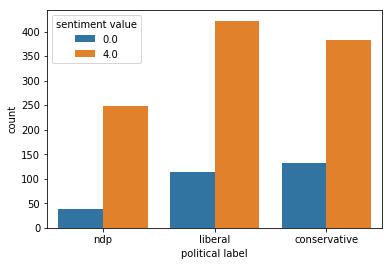

In [51]:
sns.countplot(x='political label', hue = 'sentiment value', data=plotDF)

## 5. Discussion

Based on the analysis, we first plot some charts to display the result.

In [52]:
plotDF.head()

,cleantext,political label,sentiment value
0,living dream cameraman camera cameraception ca...,ndp,4.0
1,justin trudeaus reasons thanksgiving todays mo...,liberal,4.0
6,harper $8m help countries wing govts elected c...,conservative,4.0
7,tommy taylor,ndp,4.0
10,icymi lylegreg predicting liberal_party win oc...,liberal,4.0


Create three sub-lists for each of the major party based on their political label

In [53]:
plot_l = plotDF[plotDF['political label'] == 'liberal']
plot_c = plotDF[plotDF['political label'] == 'conservative']
plot_n = plotDF[plotDF['political label'] == 'ndp']

Plot a pie chart to show the percentage distribution of three parties (the total number of tweets only including those that mentioning single party)

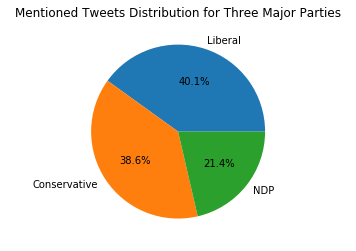

In [54]:
plt.figure(2)
party_label = ["Liberal","Conservative","NDP"]
party_sum = [(plotDF['political label'] == 'liberal').sum(), (plotDF['political label'] == 'conservative').sum(),(plotDF['political label'] == 'ndp').sum()]

plt.axis("equal")
plt.pie(party_sum, labels=party_label, autopct="%1.1f%%")
plt.title("Mentioned Tweets Distribution for Three Major Parties")

plt.show()

Plot three pie charts to show the distribution of positive and negative sentiment value for each party

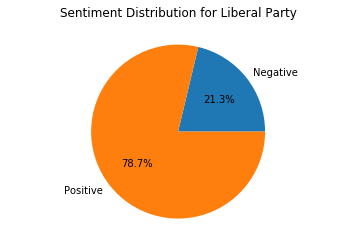

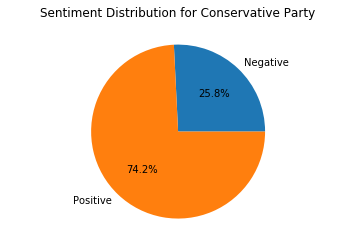

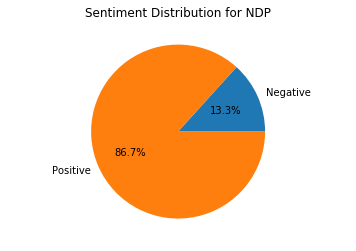

In [55]:
plt.figure(3)
senti_label = ["Negative","Positive"]
senti_l = [(plot_l['sentiment value'] == 0).sum(), (plot_l['sentiment value'] == 4).sum()]

plt.axis("equal")
plt.pie(senti_l, labels=senti_label, autopct="%1.1f%%")
plt.title("Sentiment Distribution for Liberal Party")

#--------------------------------------------------------
plt.figure(4)
senti_c = [(plot_c['sentiment value'] == 0).sum(), (plot_c['sentiment value'] == 4).sum()]

plt.axis("equal")
plt.pie(senti_c, labels=senti_label, autopct="%1.1f%%")
plt.title("Sentiment Distribution for Conservative Party")

#--------------------------------------------------------
plt.figure(5)
senti_n = [(plot_n['sentiment value'] == 0).sum(), (plot_n['sentiment value'] == 4).sum()]

plt.axis("equal")
plt.pie(senti_n, labels=senti_label, autopct="%1.1f%%")
plt.title("Sentiment Distribution for NDP")

plt.show()

#### Question of the Project:
#### What can public opinion on Twitter tell us about the Canadian political landscape in 2015?
As the results showing above, we can get the following **conclusions**:
- There are about the same number of tweets mentioning liberal and conservative party, while relatively less number of tweets mentioning NDP.
- Out of the total tweets that mentioning single political party (the tweet is about just one party), there are 40% for **liberal**, 39% for **conservative** and 21% for **NDP**
- NDP has the highest positive attitude rate; conservative party has the lowest positive attitude rate
- For **liberal**, 79% of population (tweets) has positive sentiments
- For **conservative**, 74% of population has positive sentiments
- For **NDP**, 87% of population has positive sentiments

From the tweets analysis, we can conclude the following **public opinions on the Canadian political landscape in 2015**:
* A little more then half (55%) of the public who posted on twitter are expressing their attitudes towards the three major political parties
* For people who are discussing about the major political parties, some are discussing about multiple parties, but 75% of the tweets are only about one party.
* In terms of the amount of the discussion, liberal and conservative parties have a similar popularity within the public, while NDP is less popular than these two parties.
* As for the public attitude of the three major parties, NDP has the highest positive rate and conservative has the lowest positive rate.

The above conclusions of public opinion about the three major parties seem to match the actual election outcome. Liberal party has the highest popularity among public and relatively low negative rate, which leaded to the highest number of votes.
